In [1]:
suppressPackageStartupMessages({
  library(scater)
  library(scran)
  library(edgeR)
  library(tidyverse)
  library(ComplexHeatmap)
})
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")




In [2]:
table(sce$donor, sce$tissue)

           
            Blood Normal Tumor TumorCore
  D20170222    43     69    91         0
  D20170227   131      0    92         0
  D20170322   452    182   481         0
  D20170327   454    417   785         0
  D20170412   312    236   520         0
  D20171109   569    726   591         0
  D20171215     0    243   116         0
  D20171220     0     47   558         0
  D20171229     0     41   759         0
  D20180108     0      0    70       489
  D20180110     0     13   334       196

In [3]:
sce$tissue <- ifelse(sce$tissue == 'TumorCore', "Tumor", sce$tissue)
#--- split by facs
sce.CD3 <- sce[, grepl("^CD", sce$celltype )]
sce.CD45N <- sce[, grepl("^CAF|^Hepa|^Endo|^HCC|^ICC|^LSEC|^cHCC_ICC|^VSMC", sce$celltype)]
sce.CD45P <- sce[, !grepl("^CD", sce$celltype ) & !grepl("^CAF|^Hepa|^Endo|^HCC|^ICC|^LSEC|^cHCC_ICC|^VSMC", sce$celltype)]


In [14]:
aa <- table(sce.CD45N$celltype, sce.CD45N$tissue, sce.CD45N$donor)

In [15]:
chisq.test(aa, correct = T,simulate.p.value = F)$observe

ERROR: Error in chisq.test(aa, correct = T, simulate.p.value = F): invalid 'x'


In [10]:
chisq.test(aa, simulate.p.value = T)$observe/chisq.test(aa, simulate.p.value = T)$expected

                        
                             Normal      Tumor
  CAF_C01-FAP            1.49498036 0.92049451
  CAF_C02-CD36           0.18271982 1.13127442
  cHCC_ICC_D20171229     0.00000000 1.16062352
  Endo_C01-FMO2          0.64228786 1.05745698
  Endo_C02-CD200         0.35050224 1.10432462
  Endo_C03-CXCL12        1.19147814 0.96924411
  Endo_C04-ACKR1         3.10367287 0.66210066
  Endo_C05-RBP7          2.24800750 0.79954065
  HCC_D20170322          0.00000000 1.16062352
  HCC_D20170327          0.21633947 1.12587431
  HCC_D20170412          0.00000000 1.16062352
  HCC_D20171109          0.00000000 1.16062352
  HCC_D20171220          0.00000000 1.16062352
  HCC_D20180108          0.34408278 1.10535573
  HCC_D20180110          0.00000000 1.16062352
  Hepa_C01-AdjacentLiver 7.04950087 0.02830789
  Hepa_C02-BiPotent      5.76106169 0.23526152
  ICC_D20171215          0.00000000 1.16062352
  LSEC_C01-CLEC4G        6.58474547 0.10295854
  LSEC_C02-NAMPT         6.17472190

# Tissue preference

In [164]:
plotDF <- as.data.frame.matrix(prop.table(table(sce$celltype, sce$tissue), margin = 1)) %>% 
    rownames_to_column("celltype")  %>% 
    pivot_longer(cols = c("Blood", "Normal", "Tumor"), names_to = "Tissue", values_to = "Fraction") %>%
    mutate(component = case_when(grepl("^Hepa|^HCC|^ICC|^cHCC", celltype) ~ "Epithelial",
                                 grepl("^CAF|^VSMC", celltype) ~ "Mesenchyme",
                                 grepl("^LSEC|^Endo", celltype) ~ "Endothelial",
                                 grepl("^DC", celltype) ~ "DC",
                                 grepl("^Mac|^Mono|^Mast|^ILCs", celltype) ~ "Mac/Mono/Mast",
                                 grepl("^CD", celltype) ~ "T",
                                 grepl("^B", celltype) ~ "B",
                                 grepl("^NK", celltype) ~ "NK"))

In [156]:
mc <- hclust(dist(prop.table(table(sce.CD3$celltype, sce.CD3$tissue), margin = 1)), method = 'ward.D2')
torder <- mc$labels[mc$order]

In [157]:
mc <- hclust(dist(prop.table(table(sce.CD45P$celltype, sce.CD45P$tissue), margin = 1)), method = 'ward.D2')
immuneorder <- mc$labels[mc$order]

In [158]:
mc <- hclust(dist(prop.table(table(sce.CD45N$celltype, sce.CD45N$tissue), margin = 1)), method = 'ward.D2')
stromalorder <- mc$labels[mc$order]

In [152]:
ggsci::pal_aaas()(3)

[1] "#3B4992FF" "#EE0000FF" "#008B45FF"

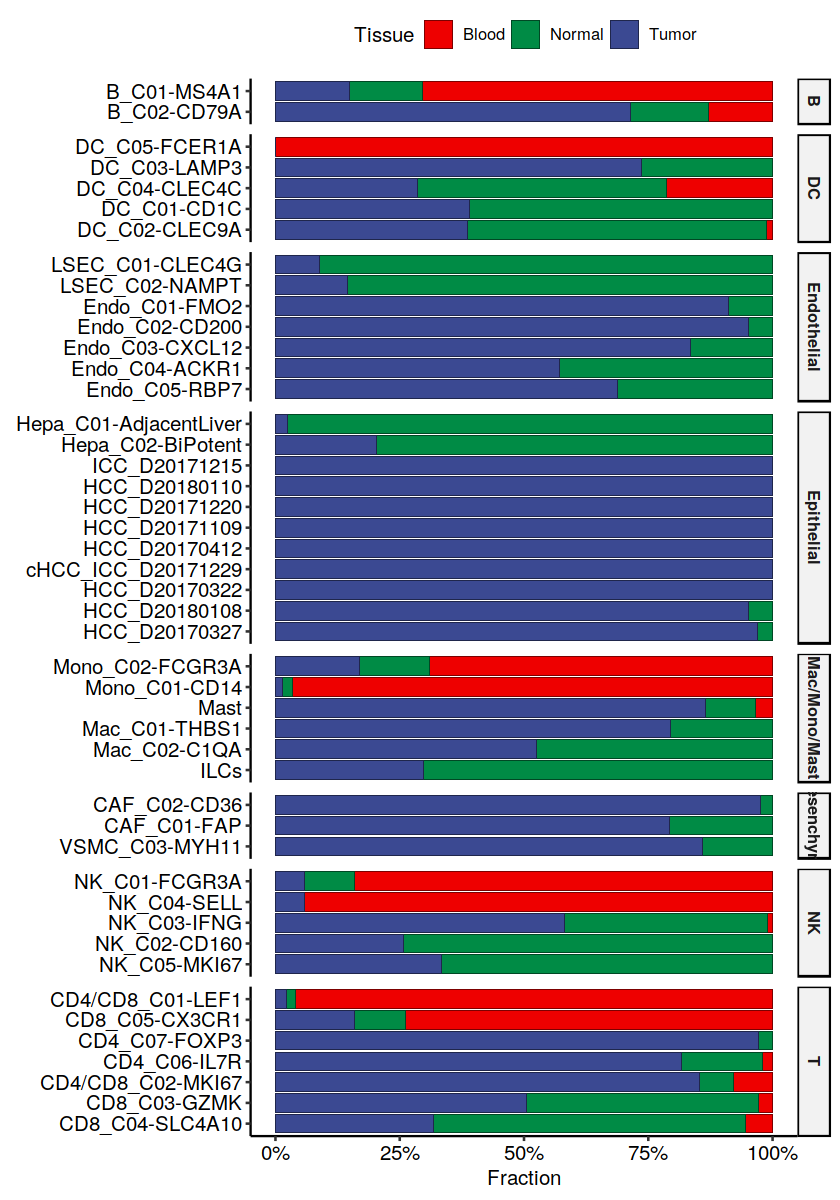

In [167]:
options(repr.plot.height = 10)
p <- plotDF %>% 
    mutate(celltype = factor(celltype, levels = rev(c(torder, immuneorder, stromalorder)))) %>%
    ggplot(aes(x = celltype, y = Fraction)) +
        geom_bar(aes(fill = Tissue), color = 'black', stat = 'identity', size = .1) +
        facet_grid(component ~ ., scale = "free", space = "free") +
        scale_y_continuous(labels = scales::percent, name = "Fraction") +
        coord_flip() +
        
        scale_fill_manual(values = c("Blood" = '#EE0000FF', "Normal"= '#008B45FF', 'Tumor' = '#3B4992FF')) +
        ggpubr::theme_pubr() + theme(axis.title.y = element_blank(), strip.text = element_text(face = 'bold') )


ggsave()

# R o/e

In [58]:
holder <- list()
e <- chisq.test(table(sce.CD3$celltype, sce.CD3$tissue))$expected
o <- chisq.test(table(sce.CD3$celltype, sce.CD3$tissue))$observed
oe <- o/e
holder[['CD3']] <- oe

In [59]:
e <- chisq.test(table(sce.CD45N$celltype, sce.CD45N$tissue))$expected
o <- chisq.test(table(sce.CD45N$celltype, sce.CD45N$tissue))$observed
oe <- o/e
holder[['CD45N']] <- oe

Warning message in chisq.test(table(sce.CD45N$celltype, sce.CD45N$tissue)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sce.CD45N$celltype, sce.CD45N$tissue)):
“Chi-squared approximation may be incorrect”


In [60]:
e <- chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue))$expected
o <- chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue))$observed
oe <- o/e
holder[['CD45P']] <- oe

Warning message in chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue)):
“Chi-squared approximation may be incorrect”


# Calculate celltype order

In [61]:
celltypes <- sapply(holder, rownames)

mt.oe <- holder$CD3
#--- Cluster t cells
tc <- hclust(dist(mt.oe[grep("^CD", rownames(mt.oe)),], method = "euclidean"), method = "complete")
torder <- tc$labels[tc$order]
torder

[1] "CD4/CD8_C01-LEF1"  "CD8_C05-CX3CR1"    "CD4_C06-IL7R"     
[4] "CD4_C07-FOXP3"     "CD4/CD8_C02-MKI67" "CD8_C03-GZMK"     
[7] "CD8_C04-SLC4A10"

In [62]:
mt.oe <- holder$CD45P
#--- Cluster t cells

#--- Cluster nk cells
nkc <-  hclust(dist(mt.oe[grep("^NK", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
nkorder <- nkc$labels[nkc$order]
#nkorder <- c("NK-C04-IL7R", "NK-C08-HSPA1A", "NK-C09-CD160", "NK-C10-MKI67", "NK-C07-IFNG", 
#             "NK-C03-SELL", "NK-C01-FGFBP2", "NK-C02-HLA-B", "NK-C05-HLA-DRA",
#             "NK-C06-XCL1")
#--- Cluster macrophage cells
mc <-  hclust(dist(mt.oe[grep("^M", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
mcorder <- mc$labels[mc$order]
#---- Cluster nk cells
dc <-  hclust(dist(mt.oe[grep("^DC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
dcorder <- dc$labels[dc$order]



In [63]:
mt.oe <- holder$CD45N
#---- Cluster endo cells
endo <-  hclust(dist(mt.oe[grep("^Endo|LSEC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
endoorder <- endo$labels[endo$order]
#---- Cluster CAF cells
caf <-  hclust(dist(mt.oe[grep("^CAF|^VSMC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
caforder <- caf$labels[caf$order]

#---- Cluster Malig cells
magli <-  hclust(dist(mt.oe[grep("^HCC|^ICC|^Hepa|^cHCC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
magliorder <- magli$labels[magli$order]



# Heatmap

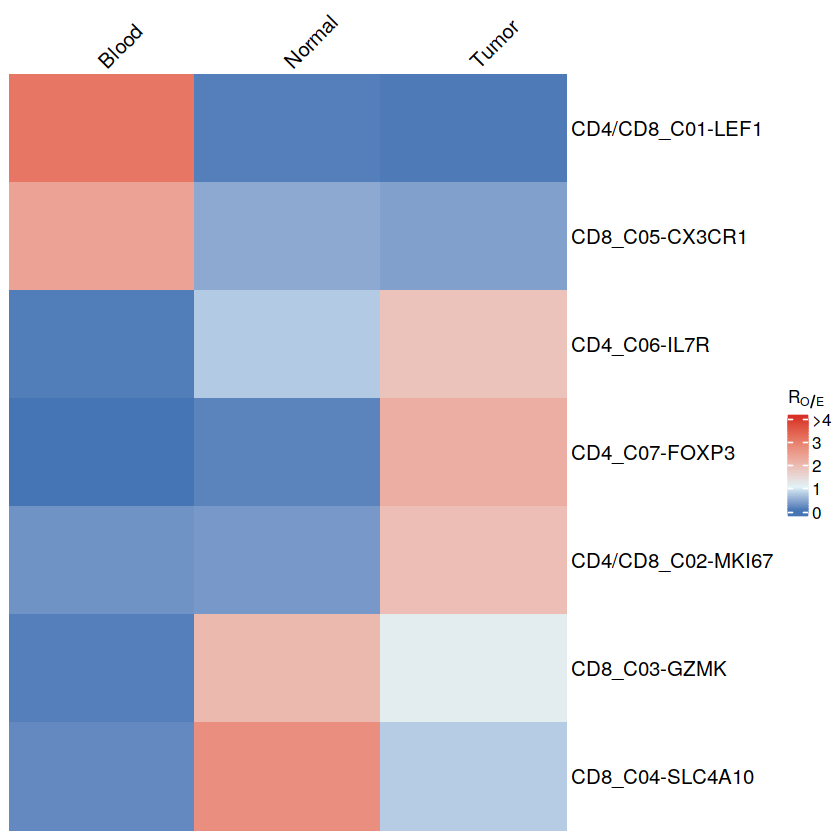

In [64]:
cols <- circlize::colorRamp2(c(0, 1, 4), rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu"))[c(1,3,7)])
mt.oe <- holder$CD3
class(mt.oe) <- 'matrix'

                    

ht.tcell <- Heatmap(mt.oe[torder,],
        col = cols,row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
        #col = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu")))(100),
        cluster_rows = F ,
        cluster_columns = F, column_names_side = "top",
        heatmap_legend_param = list(title = expression(R[O/E]), labels = c("0", "1", "2", "3", ">4")))

ht.tcell


In [65]:
celltype.order <- c(nkorder, mcorder,  dcorder, 
                    "ILCs", "B_C01-MS4A1", "B_C02-CD79A")

,Blood,Normal,Tumor,TumorCore
NK_C01-FCGR3A,2.36741947,0.36164011,0.16210662,0.0000000
NK_C04-SELL,2.64928931,0.00000000,0.16496732,0.0000000
NK_C03-IFNG,0.02852909,1.46143098,1.62960961,0.0000000
NK_C02-CD160,0.00000000,2.65778291,0.71956140,0.0000000
NK_C05-MKI67,0.00000000,2.38338055,0.93481481,0.0000000
Mono_C01-CD14,2.71581288,0.07338855,0.04112089,0.0000000
Mono_C02-FCGR3A,1.94128958,0.50852300,0.47143678,0.0000000
Mac_C02-C1QA,0.00000000,1.70057423,1.47043844,0.0000000
Mac_C01-THBS1,0.00000000,0.73060030,2.22368756,0.3223774
Mast,0.09541932,0.36356652,2.42418079,0.0000000


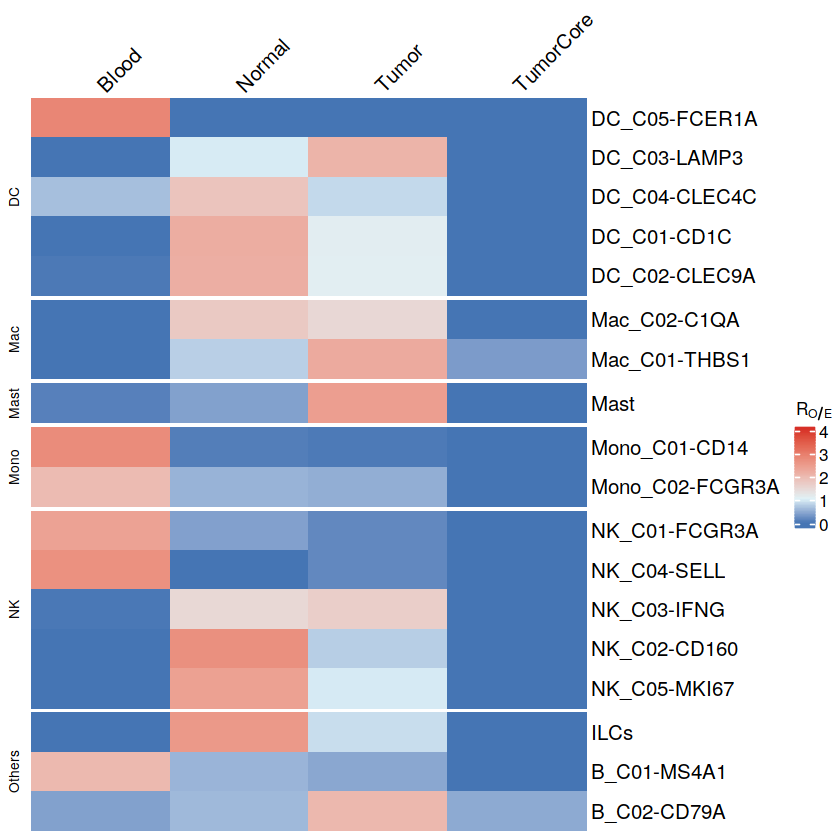

In [66]:
mt.oe <- as.matrix(holder$CD45P)
class(mt.oe) <- 'matrix'
celltype.order <- c(nkorder, mcorder,  dcorder, 
                    "ILCs", "B_C01-MS4A1", "B_C02-CD79A")
mt.oe[celltype.order,]
ht.immune <- Heatmap(mt.oe[celltype.order,],
                    col = cols,
                    #col = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu")))(100),
                    cluster_rows = F ,row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
                    row_split = c(rep("NK", 5), rep("Mono", 2), rep("Mac", 2), rep("Mast", 1), rep("DC", 5), rep("Others", 3)),
                    cluster_columns = F, column_names_side = "top",
                    heatmap_legend_param = list(title = expression(R[O/E], labels = c("0", "1", "2", "3", ">4"))))
ht.immune

In [67]:
mt.oe <- as.matrix(holder$CD45N)
rownames(mt.oe)

[1] "CAF_C01-FAP"            "CAF_C02-CD36"           "cHCC_ICC_D20171229"    
 [4] "Endo_C01-FMO2"          "Endo_C02-CD200"         "Endo_C03-CXCL12"       
 [7] "Endo_C04-ACKR1"         "Endo_C05-RBP7"          "HCC_D20170322"         
[10] "HCC_D20170327"          "HCC_D20170412"          "HCC_D20171109"         
[13] "HCC_D20171220"          "HCC_D20180108"          "HCC_D20180110"         
[16] "Hepa_C01-AdjacentLiver" "Hepa_C02-BiPotent"      "ICC_D20171215"         
[19] "LSEC_C01-CLEC4G"        "LSEC_C02-NAMPT"         "VSMC_C03-MYH11"

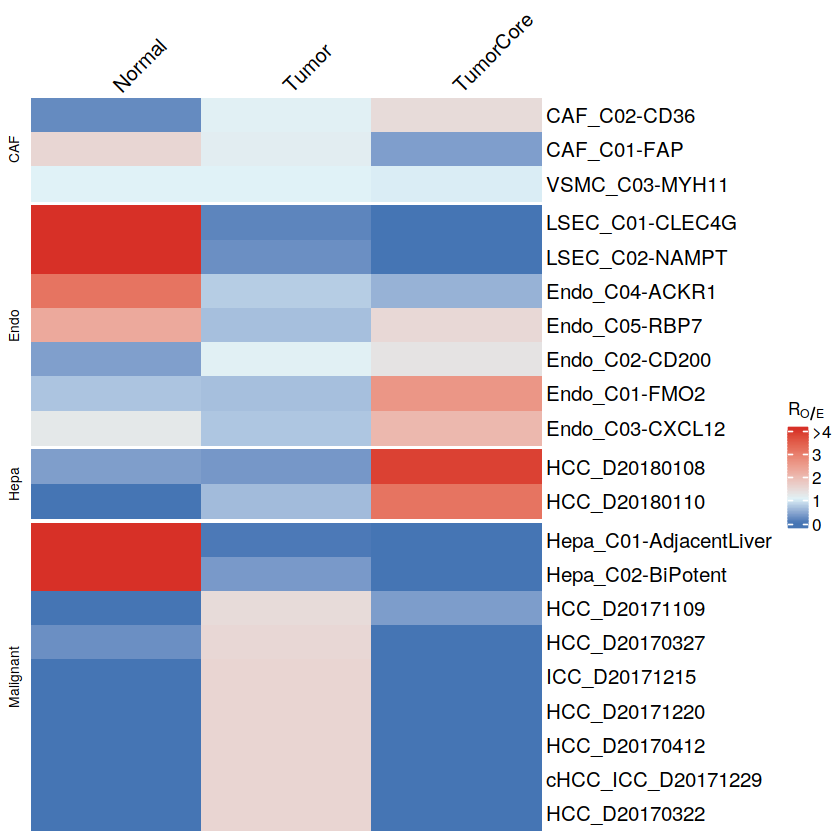

In [68]:
mt.oe <- as.matrix(holder$CD45N)

class(mt.oe) <- 'matrix'
celltype.order <- c(caforder, endoorder, magliorder) 

ht.CD45N <- Heatmap(mt.oe[celltype.order,],
                    col = cols,
                    row_split = c(rep("CAF", 3), rep("Endo", 7), rep("Malignant", 9), rep("Hepa", 2)),
                    cluster_rows = F , row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
                    cluster_columns = F, column_names_side = "top",
                    heatmap_legend_param = list(title = expression(R[O/E]), labels = c("0", "1", "2", "3", ">4")))
ht.CD45N

In [15]:

#table(sce.CD45N$cluster_final, sce.CD45N$tissue)


e <- chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue))$expected
o <- chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue))$observed
oe <- o/e
mt.oe <- as.matrix(oe)


#holder[['CD45P']] <- oe
#--- Cluster nk cells
nkc <-  hclust(dist(mt.oe[grep("^NK", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
nkorder <- nkc$labels[nkc$order]
#nkorder <- c("NK-C04-IL7R", "NK-C08-HSPA1A", "NK-C09-CD160", "NK-C10-MKI67", "NK-C07-IFNG", 
#             "NK-C03-SELL", "NK-C01-FGFBP2", "NK-C02-HLA-B", "NK-C05-HLA-DRA",
#             "NK-C06-XCL1")
#--- Cluster macrophage cells
mc <-  hclust(dist(mt.oe[grep("^Mac|^Mono|^Mast", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
mcorder <- mc$labels[mc$order]
#---- Cluster nk cells
dc <-  hclust(dist(mt.oe[grep("^DC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
dcorder <- dc$labels[dc$order]



Warning message in chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sce.CD45P$celltype, sce.CD45P$tissue)):
“Chi-squared approximation may be incorrect”


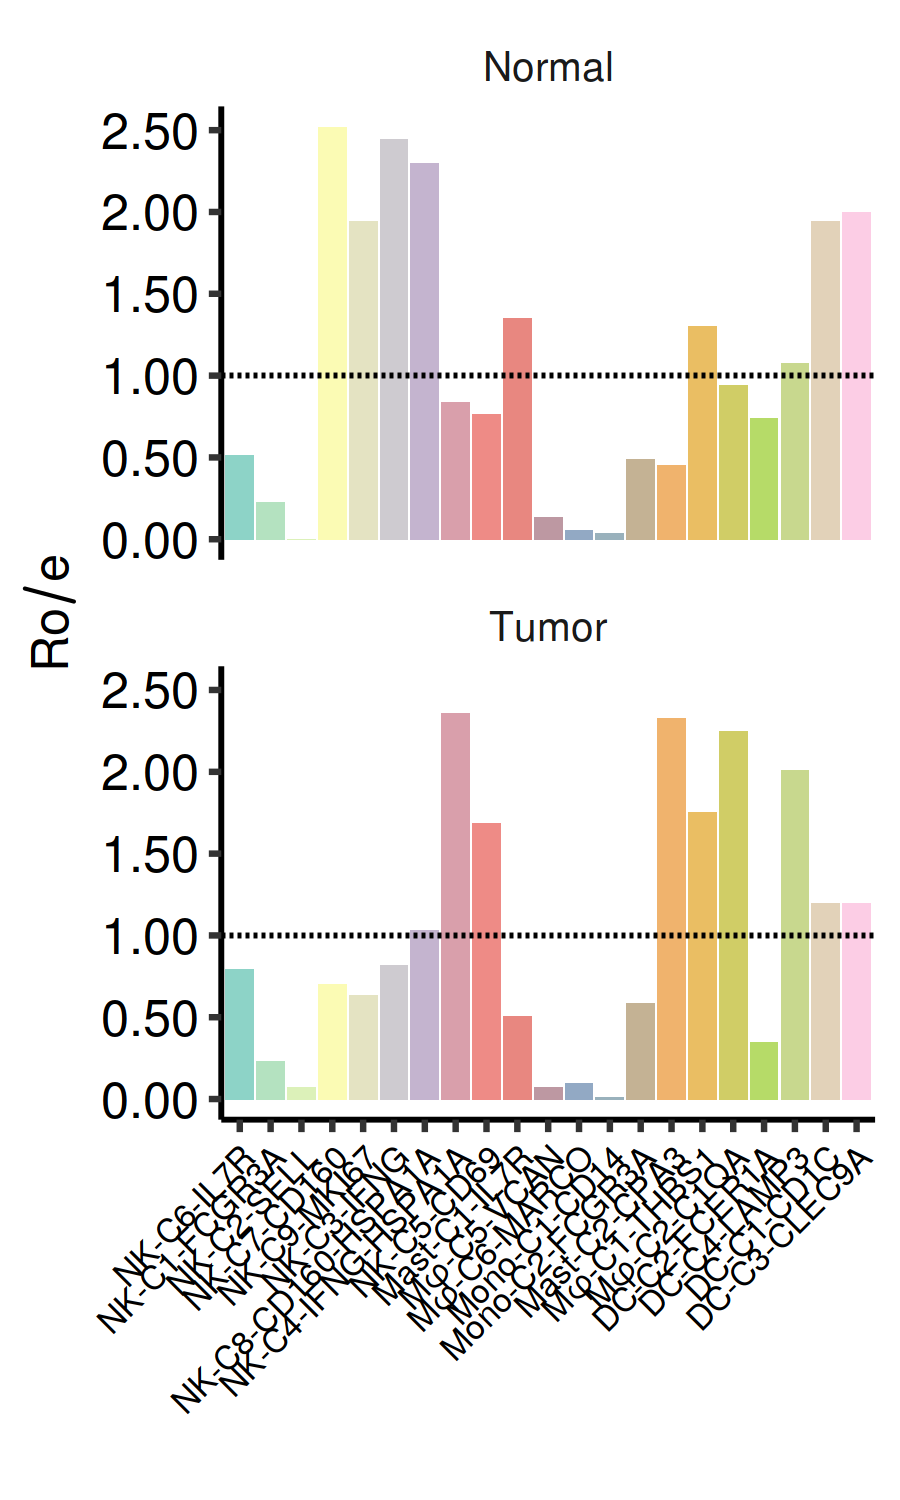

In [54]:
pal <- RColorBrewer::brewer.pal(n = 8, name = "Set3")
cols <- colorRampPalette(pal)(length(unique(sce.CD45P$celltype_CD45P)))
p <- data.frame(oe) %>% 
     filter(Var2 %in% c("Tumor", "Normal")) %>% 
    mutate(Var1 = factor(Var1, levels = c(nkorder, mcorder, dcorder))) %>% 
    #filter(!(Var2 %in% c("Ascites", "Lymphnode"))) %>%
    ggplot(aes(x = Var1, y = Freq)) +
        geom_bar(aes(fill = Var1), stat = 'identity', position = 'dodge')  + 
        geom_hline(aes(yintercept = 1), linetype = 2) + 
        scale_y_continuous(labels = scales::label_number(scale = 1)) +
        scale_fill_manual(values = cols) + 
        facet_wrap(. ~ Var2, ncol = 1) +
        xlab("") + 
        ggpubr::theme_pubr() + ylab(expression(Ro/e)) + 
        theme(legend.position = "none", axis.text.x = element_text(size = 8, angle = 45, hjust = 1, vjust= 1), strip.background = element_blank())
p

# Old

In [ ]:
celltypes <- sapply(holder, rownames)

mt.oe <- holder$CD3
#--- Cluster t cells
tc <- hclust(dist(mt.oe[grep("^CD", rownames(mt.oe)),], method = "euclidean"), method = "complete")
torder <- tc$labels[tc$order]
torder
#torder <- c("T-C5-FOXP3", "T-C13-MKI67", "T-C12-PDCD1", "T-C7-GZMK", "T-C8-XCL1", "T-C11-KLRF1", 
#            "T-C9-SLC40A1", "T-C6-CX3CR1", "T-C1-CCR7", "T-C4-ANXA1", "T-C10-HLA-DRA", "T-C3-IL7R")

mt.oe <- holder$CD45P
#--- Cluster t cells

#--- Cluster nk cells
nkc <-  hclust(dist(mt.oe[grep("^NK", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
nkorder <- nkc$labels[nkc$order]
#nkorder <- c("NK-C04-IL7R", "NK-C08-HSPA1A", "NK-C09-CD160", "NK-C10-MKI67", "NK-C07-IFNG", 
#             "NK-C03-SELL", "NK-C01-FGFBP2", "NK-C02-HLA-B", "NK-C05-HLA-DRA",
#             "NK-C06-XCL1")
#--- Cluster macrophage cells
mc <-  hclust(dist(mt.oe[grep("^Mφ", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
mcorder <- mc$labels[mc$order]
#---- Cluster nk cells
dc <-  hclust(dist(mt.oe[grep("^DC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
dcorder <- dc$labels[dc$order]

mt.oe <- holder$CD45N
#---- Cluster endo cells
endo <-  hclust(dist(mt.oe[grep("^Endo|LSEC", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
endoorder <- endo$labels[endo$order]


#---- Cluster CAF cells
caf <-  hclust(dist(mt.oe[grep("CAF", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
caforder <- caf$labels[caf$order]

#---- Cluster Malig cells
magli <-  hclust(dist(mt.oe[grep("Malignant", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
magliorder <- magli$labels[magli$order]

#---- Cluster MixedCC
mixed <-  hclust(dist(mt.oe[grep("Mixed", rownames(mt.oe)),], method = "euclidean"), method = "ward.D2") 
mixedorder <- mixed$labels[mixed$order]




In [ ]:
cols <- circlize::colorRamp2(c(0, 1, 4), rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu"))[c(1,3,7)])
mt.oe <- holder$CD3
class(mt.oe) <- 'matrix'
celltype.order <- c(torder, nkorder, mcorder,  dcorder, 
                    "Mast-C1-IL7R", "Mast-C2-CPA3", "Mono-C1-CD14", "Mono-C2-FCGR3A", "ILCs", "Lymphocytes-B", "Lymphocytes-B-Plasma")
                    

ht.tcell <- Heatmap(mt.oe[torder,],
        col = cols,row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
        #col = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu")))(100),
        cluster_rows = F ,
        cluster_columns = F, column_names_side = "top",
        heatmap_legend_param = list(title = expression(R[O/E]), labels = c("0", "1", "2", "3", ">4")))

ht.tcell
mt.oe <- as.matrix(holder$CD45P)
class(mt.oe) <- 'matrix'
celltype.order <- c(nkorder, mcorder,  dcorder, 
                    "Mast-C1-IL7R", "Mast-C2-CPA3", "Mono-C1-CD14", "Mono-C2-FCGR3A", "ILCs", "Lymphocytes-B", "Lymphocytes-B-Plasma")

mt.oe[celltype.order,]
ht.immune <- Heatmap(mt.oe[celltype.order,],
                    col = cols,
                    #col = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name ="RdYlBu")))(100),
                    cluster_rows = F ,row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
                    row_split = c(rep("NK", 9), rep("Marcophage", 6), rep("DC", 4), rep("Mast", 2), rep("Mono", 2), rep("Others", 3)),
                    cluster_columns = F, column_names_side = "top",
                    heatmap_legend_param = list(title = expression(R[O/E], labels = c("0", "1", "2", "3", ">4"))))

mt.oe <- as.matrix(holder$CD45N)

class(mt.oe) <- 'matrix'
celltype.order <- c(caforder, endoorder, magliorder, mixedorder,  "hLPSs_Duct-C01", "hLPSs_Duct-C02", "Hepatocytes" ) 

ht.CD45N <- Heatmap(mt.oe[celltype.order,],
                    col = cols,
                    row_split = c(rep("CAF", 4), rep("Endo", 6), rep("Malignant", 13), rep("MixedCC", 5), rep("Hepa", 3)),
                    cluster_rows = F , row_title_gp = gpar(fontsize = 8), , column_names_rot = 45,
                    cluster_columns = F, column_names_side = "top",
                    heatmap_legend_param = list(title = expression(R[O/E]), labels = c("0", "1", "2", "3", ">4")))
ht.CD45N
pdf("./figures/tissuePreference/Heatmap_SMARTSeq2_Tcell_Roe.pdf", width = 3.2, height = 3)
draw(ht.tcell)
dev.off()


pdf("./figures/tissuePreference/Heatmap_SMARTSeq2_Immune_Roe.pdf", width = 4, height = 6)
draw(ht.immune)
dev.off()


pdf("./figures/tissuePreference/Heatmap_SMARTSeq2_Stromal_Roe.pdf", width = 4, height = 8)
draw(ht.CD45N)
dev.off()